In [30]:
import pandas as pd
import numpy as np

from src.OLS import OLS
from src.StandardScaler import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from src.stat_tests import VectorKS2Samp

In [31]:
s = StandardScaler()
rgdp = pd.read_csv('./data/fred/GDPC1.csv', low_memory=False, encoding='utf-8')
tcu = pd.read_csv('./data/fred/CPIAUCSL.csv', low_memory=False, encoding='utf-8')
fedrate = pd.read_csv('./data/fred/UNRATE.csv', low_memory=False, encoding='utf-8')
netexp = pd.read_csv('./data/fred/NETEXP.csv', low_memory=False, encoding='utf-8')
set = [rgdp, tcu, fedrate, netexp]
for df in set:
    df.set_index("observation_date", inplace=True)


<Axes: >

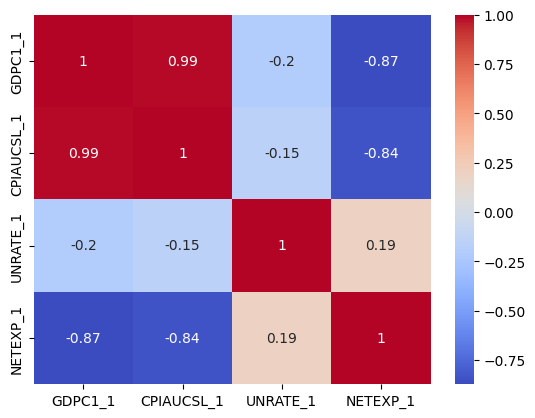

In [32]:
target = pd.Series(rgdp['GDPC1'])
X = pd.concat([rgdp, tcu.loc[rgdp.index], fedrate.loc[rgdp.index], netexp.loc[rgdp.index]], axis=1)
X = X.shift(1).dropna(how='any')
cols = X.columns.tolist()
X.columns = [col + "_1" for col in cols]
X_2 = X.shift(1)

target = target.loc[X.index]

assert X.notna().all().all() == target.notna().all().all() == True, len(X) == len(target)
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')

In [33]:
# House Price Data Prep
# yn_map = {"yes": 1, "no": 0}
y = target.values
X = X.values

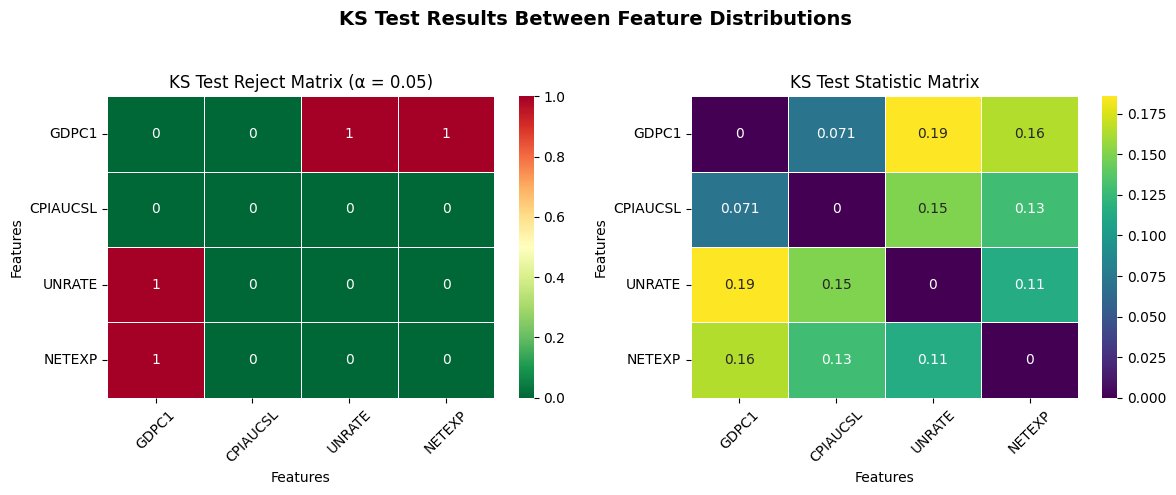

reject: False
pval: 0.867425867385816
test_stat: 0.0714285714285714
stat_name: Standardized Kolmogorov-Smirnov Test (D Statistic)

In [34]:
ks_stats, ks_reject, tests = VectorKS2Samp(X, alpha=0.05)
ks_reject = pd.DataFrame(ks_reject, index=cols, columns=cols)
ks_stats = pd.DataFrame(ks_stats, index=cols, columns=cols)

ks_pvals = [[tests[i,j].pval for j in range(len(cols))] for i in range(len(cols))]
ks_pvals = pd.DataFrame(ks_pvals, index=cols, columns=cols)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# KS Reject Matrix (green → red)
sns.heatmap(
    ks_reject, annot=True, cmap="RdYlGn_r", 
    ax=ax[0], cbar=True, linewidths=0.5, linecolor="white"
)
ax[0].set_title("KS Test Reject Matrix (α = 0.05)", fontsize=12)
ax[0].set_xlabel("Features")
ax[0].set_ylabel("Features")
ax[0].tick_params(axis="x", rotation=45)
ax[0].tick_params(axis="y", rotation=0)

# KS Statistic Matrix (viridis)
sns.heatmap(
    ks_stats, annot=True, cmap="viridis", 
    ax=ax[1], cbar=True, linewidths=0.5, linecolor="white"
)
ax[1].set_title("KS Test Statistic Matrix", fontsize=12)
ax[1].set_xlabel("Features")
ax[1].set_ylabel("Features")
ax[1].tick_params(axis="x", rotation=45)
ax[1].tick_params(axis="y", rotation=0)


# Add a main title and adjust layout
plt.suptitle("KS Test Results Between Feature Distributions", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

tests[0,1]

In [35]:
pvals = [[tests[i,j].pval for j in range(len(cols))] for i in range(len(cols))]
pval_matrix = pd.DataFrame(pvals, index=cols, columns=cols)
pval_matrix

,GDPC1,CPIAUCSL,UNRATE,NETEXP
GDPC1,0.000000,0.867426,0.015996,0.045710
CPIAUCSL,0.867426,0.000000,0.085698,0.197483
UNRATE,0.015996,0.085698,0.000000,0.319954
NETEXP,0.045710,0.197483,0.319954,0.000000


In [36]:
# X_test = X[-1]
# y_yest = y[-1]

X_fit = X
y_fit = y

ols = OLS(X_fit, y_fit)
fit = ols.fit(diagnosis_trend="ctt")
fit.fitted_values

array([10094.75134166, 10131.14035665, 10142.49283276, 10066.95332437,
       10037.77739373, 10125.23194116, 10179.85339989, 10222.65262007,
       10354.6304205 , 10469.89082325, 10583.36270736, 10678.60669229,
       10697.0742951 , 10752.0858923 , 10796.0747814 , 10938.18491568,
       11036.44477523, 11177.8943165 , 11232.61707832, 11349.93158636,
       11383.36413987, 11425.0424935 , 11516.90317462, 11587.55676289,
       11678.5491545 , 11872.587451  , 11975.8123366 , 12088.10354629,
       12170.50528969, 12363.8630857 , 12510.68571944, 12610.98166427,
       12734.1715255 , 12841.72993335, 13010.78511486, 13219.56658199,
       13337.58539756, 13450.29117185, 13629.22559221, 13846.22443233,
       13895.27132514, 14141.13554892, 14164.75818401, 14246.6321265 ,
       14211.48191812, 14305.97920204, 14256.92363952, 14321.02933706,
       14454.88268111, 14552.18832191, 14608.27372779, 14624.98003281,
       14706.67958742, 14842.99544673, 15094.84698765, 15261.9180662 ,
      

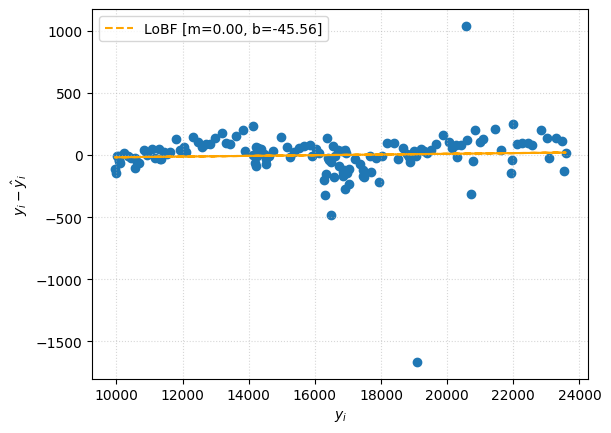

In [37]:
n = len(fit.resid)
m, b = np.polyfit(y_fit, fit.resid, 1)

line = m * y_fit + b


plt.scatter(y_fit, fit.resid)
plt.plot(y_fit, line, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle="--", color="orange")

plt.xlabel(r"$y_i$")
plt.ylabel(r"$y_i - \hat{y}_i$")

plt.grid(alpha=0.5, linestyle=":")

plt.legend()
plt.show()

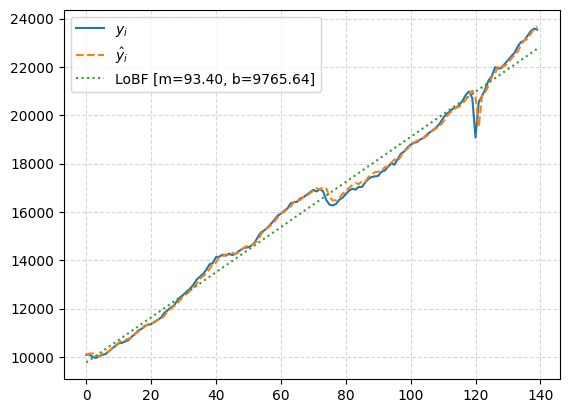

In [38]:
x = np.array([i for i in range(len(y_fit))])
m, b = np.polyfit(x, y_fit, 1)
plt.plot(x, y_fit, label=r"$y_i$")
plt.plot(x, fit.fitted_values, label=r"$\hat{y}_i$", linestyle="--")
plt.plot(x, m*x + b, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle=":")

plt.grid(alpha=0.5, linestyle="--")
plt.legend()
plt.show()

In [39]:
fit.resid_heteroske

reject: False
pval: 0.930863530294225
test_stat: 8.696973072728355
stat_name: Breusch-Pagan Test (Chi^2 Statistic)

In [40]:
# print(ols.predict(X_test))
fit.resid_normality

reject: True
pval: 2.2240596029259064e-17
test_stat: 0.6242200379821429
stat_name: Shapiro-Wilk Test (Approximated Z-Statistic)

In [41]:
fit.resid_stationarity

reject: False
pval: 0.4623587679558643
test_stat: -2.685881016308958
stat_name: ADF Test (T-Statistic)

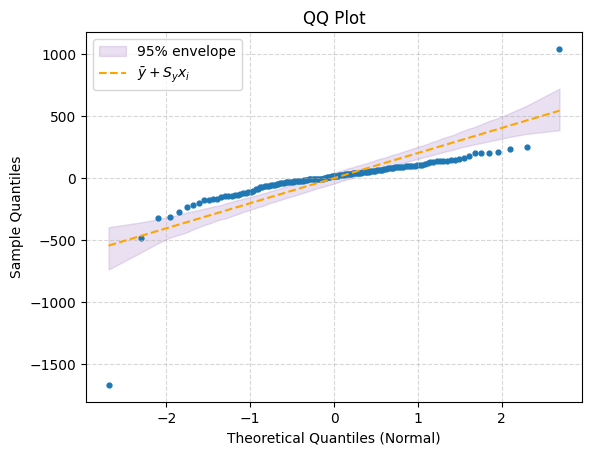

In [42]:
fit.qq(line="45", band=0.95)

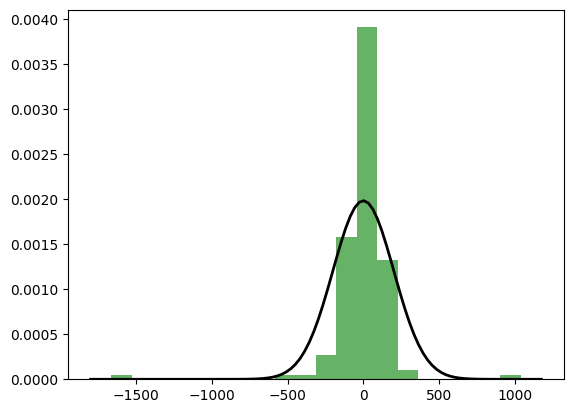

In [43]:
from scipy.stats import norm
plt.hist(fit.resid, bins=20, density=True, alpha=0.6, color='g')
mu, std = norm.fit(fit.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()